In [36]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 18.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import os
import random
import cv2
from skimage import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
import tensorflow as tf
import re

random.seed(10)

In [26]:
# Function to calculate SSIM between two images
def calculate_ssim(image1, image2):
    # Resize image2 to match image1's size
    image2_resized = cv2.resize(image2, (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_AREA)
    
    # Convert both images to grayscale
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2_resized, cv2.COLOR_BGR2GRAY)
    
    # Calculate SSIM score
    ssim_score, _ = metrics.structural_similarity(image1_gray, image2_gray, full=True)
    
    return ssim_score

In [7]:
def extract_dimensions(image_name):
    # Remove file extension and split by '_'
    base_name = image_name.split('.')[0]
    dimensions = base_name.split('_')
    
    # Create a dictionary to hold dimension values
    dimension_values = {}
    for dim in dimensions:
        # Dimension abbreviation is three uppercase letters, followed by its value
        if len(dim) > 3:
            key = dim[:3]  # The code (e.g., 'BOD')
            value = int(re.search(r'\d+', dim).group())  # Extract numeric value
            dimension_values[key] = value
    return dimension_values

# Function to calculate similarity score between two sets of dimension values
def calculate_similarity_score(dim_values1, dim_values2):
    score = 0
    for key in dim_values1.keys():
        if key in dim_values2:
            # Apply weights based on the dimension code
            if key == 'BOD':
                weight = 2
            elif key in ['BMC', 'BCC', 'BPT']:
                weight = 1.5
            elif key == 'FRC':
                weight = 0.25
            elif key == 'HEA':
                weight = 1
            elif key in ['HMC', 'HCC', 'HPT']:
                weight = 0.75
            elif key in ['ELT', 'ERT', 'ELL', 'ERL']:
                weight = 0.25
            elif key in ['AAL', 'AAR']:
                weight = 0.25
            elif key == 'BEK':
                weight = 0.25
            else:
                weight = 1
            
            # Add weight to score if the values are equal for this dimension
            if dim_values1[key] == dim_values2[key]:
                score += weight
                
    return score

# Function to compare two image names and calculate their similarity score
def compare_image_names(image_name1, image_name2):
    # Extract dimension values from both image names
    dim_values1 = extract_dimensions(image_name1)
    dim_values2 = extract_dimensions(image_name2)
    
    # Calculate similarity score based on extracted dimensions
    score = calculate_similarity_score(dim_values1, dim_values2)
    
    return score

In [6]:
def load_images_and_filenames(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

In [26]:
def compute_ssim_distribution(folder_path, num_pairs=50):
    # Load all images from the folder
    images, filenames = load_images_and_filenames(folder_path)
    
    if len(images) < 2:
        print("Not enough images in the folder.")
        return
    
    ssim_scores = []
    
    # Randomly select pairs of images and compute SSIM scores
    for _ in range(num_pairs):
        img1, img2 = random.sample(images, 2)  # Randomly pick two different images
        ssim_score = calculate_ssim(img1, img2)
        ssim_scores.append(ssim_score)
    
    # Plotting the distribution of SSIM scores
    plt.figure(figsize=(10, 6))
    plt.hist(ssim_scores, bins=10, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of SSIM Scores')
    plt.xlabel('SSIM Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [106]:
# Main function to randomly draw pairs of images from a folder and calculate SSIM and SS scores
def random_draw_and_plot(folder_path, num_pairs=10):
    # Load all images and their filenames from the folder
    random.seed(1)
    images, filenames = load_images_and_filenames(folder_path)
    
    if len(images) < 2:
        print("Not enough images in the folder.")
        return
    
    ssim_scores = []
    ss_scores = []
    
    # Randomly select pairs of images and calculate both SSIM and SS scores
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(images)), 2)  # Randomly select two different indices
        
        img1, img2 = images[idx1], images[idx2]
        fname1, fname2 = filenames[idx1], filenames[idx2]
        
        # Calculate SSIM score for the pair of images
        ssim_score = calculate_ssim(img1, img2)
        ssim_scores.append(ssim_score)
        
        # Extract dimensions from filenames and calculate similarity score (SS)
        dim_values1 = extract_dimensions(fname1)
        dim_values2 = extract_dimensions(fname2)
        
        ss_score = calculate_similarity_score(dim_values1, dim_values2)
        ss_scores.append(ss_score)

    # Normalize both SSIM and SS scores to [0, 1]
    ssim_scores_normalized = (np.array(ssim_scores) - np.min(ssim_scores)) / (np.max(ssim_scores) - np.min(ssim_scores))
    ss_scores_normalized = (np.array(ss_scores) - np.min(ss_scores)) / (np.max(ss_scores) - np.min(ss_scores))
    
     # Perform linear regression on normalized scores using sklearn's LinearRegression model
    X = ssim_scores_normalized.reshape(-1, 1)  # Reshape for sklearn's LinearRegression input format (n_samples, n_features)
    y = ss_scores_normalized
    
    model = LinearRegression()
    model.fit(X, y)

     # Get regression line values: y_predicted based on X values (SSIM scores)
    y_predicted = model.predict(X)

    # Get slope (coefficient) and intercept of regression line
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate R-squared value for goodness-of-fit measure
    r_squared = model.score(X, y)

    # Plotting the scatter plot of normalized SSIM vs SS scores with regression line
    plt.figure(figsize=(6, 6))  # Set figure size to be square
    
    plt.scatter(ssim_scores_normalized, ss_scores_normalized, color='blue', alpha=0.5, label='Data points')
    
    # Plot regression line on top of scatter plot
    plt.plot(ssim_scores_normalized, y_predicted, color='red', label=f'Regression Line: y={slope:.3f}x + {intercept:.3f}')
    
    # Add title and labels with R-squared value displayed on the plot
    plt.title(f'Scatter Plot of Normalized SSIM vs Similarity Score (SS)\nR²={r_squared:.3f}')
    
    plt.xlabel('Normalized SSIM Score')
    plt.ylabel('Normalized Similarity Score (SS)')
    
    # Make sure the figure is square-shaped by setting equal aspect ratio for x and y axes.
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend()
    plt.savefig('/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/SSIM.eps', format='eps')
    plt.show()
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


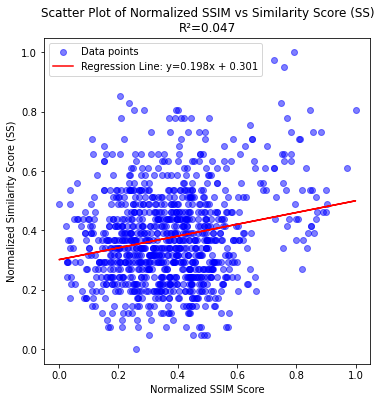

In [107]:
# Example usage:
folder_path = '/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/CONFIGS/SStest/Stims/Stimuli/RenderPics'
random_draw_and_plot(folder_path, num_pairs=1000)

In [34]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from skimage import metrics
from scipy.stats import norm

In [53]:
def extract_features(image, model):
    # Convert image to RGB if it's grayscale
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    # Resize image to 224x224 (EfficientNetB0 required input size)
    image_resized = cv2.resize(image, (224, 224))
    
    # Preprocess the image for EfficientNet
    image_preprocessed = preprocess_input(image_resized)
    
    # Add batch dimension
    image_batch = np.expand_dims(image_preprocessed, axis=0)
    
    # Get features from the model
    features = model.predict(image_batch, verbose=0)
    
    return features.flatten()

def plot_ssim_efficientnet_correlation(folder_path, num_pairs=10):
    # Set random seed for reproducibility
    random.seed(1)
    
    # Load EfficientNetB0 model
    base_model = EfficientNetB0(weights='imagenet', include_top=True)
    
    # Load images and filenames
    images, filenames = load_images_and_filenames(folder_path)
    
    if len(images) < 2:
        print("Not enough images in the folder.")
        return
    
    ssim_scores = []
    efficientnet_similarities = []
    
    # Calculate scores for random image pairs
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(images)), 2)
        img1, img2 = images[idx1], images[idx2]
        
        # Calculate SSIM score
        ssim_score = calculate_ssim(img1, img2)
        ssim_scores.append(ssim_score)
        
        # Extract EfficientNet features and calculate cosine similarity
        features1 = extract_features(img1, base_model)
        features2 = extract_features(img2, base_model)
        
        similarity = cosine_similarity(features1.reshape(1, -1), 
                                     features2.reshape(1, -1))[0][0]
        efficientnet_similarities.append(similarity)
    
    # Normalize scores to [0, 1] range
    ssim_normalized = (np.array(ssim_scores) - np.min(ssim_scores)) / \
                     (np.max(ssim_scores) - np.min(ssim_scores))
    efficientnet_normalized = (np.array(efficientnet_similarities) - np.min(efficientnet_similarities)) / \
                            (np.max(efficientnet_similarities) - np.min(efficientnet_similarities))
    
    # Perform linear regression
    X = ssim_normalized.reshape(-1, 1)
    y = efficientnet_normalized
    
    model = LinearRegression()
    model.fit(X, y)
    y_predicted = model.predict(X)
    
    # Calculate regression statistics
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(ssim_normalized, efficientnet_normalized, 
               color='blue', alpha=0.5, label='Data points')
    plt.plot(ssim_normalized, y_predicted, 
            color='red', label=f'Regression Line: y={slope:.3f}x + {intercept:.3f}')
    
    plt.title(f'SSIM vs EfficientNetB0 Similarity Correlation\nR²={r_squared:.3f}')
    plt.xlabel('Normalized SSIM Score')
    plt.ylabel('Normalized EfficientNetB0 Similarity')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.savefig('SSIM_EfficientNet_Correlation.eps', format='eps')
    plt.show()
    
    return ssim_normalized, efficientnet_normalized, r_squared

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


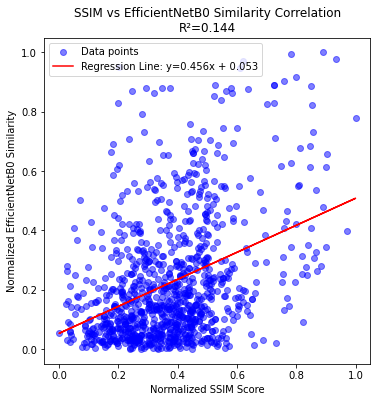

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


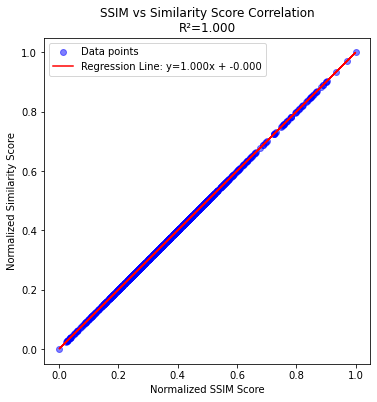

In [58]:
folder_path = '/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/CONFIGS/SStest/Stims/Stimuli/RenderPics'
ssim_scores, efficientnet_scores, r2 = plot_ssim_efficientnet_correlation(folder_path, num_pairs=1000)

In [55]:
def analyze_similarity_distributions(folder_path, n_pairs=10, n_bins=5, seed = 42):
    # Get random pairs and calculate scores
    random.seed(seed)
    np.random.seed(seed)
    images, filenames = load_images_and_filenames(folder_path)
    
    similarity_scores = []
    ssim_scores = []
    
    for _ in range(n_pairs):
        idx1, idx2 = random.sample(range(len(images)), 2)
        img1, img2 = images[idx1], images[idx2]
        
        # Calculate SSIM
        ssim_value = calculate_ssim(img1, img2)
        ssim_scores.append(ssim_value)
        
        # Calculate similarity score from filenames
        dim_values1 = extract_dimensions(filenames[idx1])
        dim_values2 = extract_dimensions(filenames[idx2])
        similarity = calculate_similarity_score(dim_values1, dim_values2)
        similarity_scores.append(similarity)
    
    # Normalize scores
    sim_norm = (np.array(similarity_scores) - np.min(similarity_scores)) / \
               (np.max(similarity_scores) - np.min(similarity_scores))
    ssim_norm = (np.array(ssim_scores) - np.min(ssim_scores)) / \
                (np.max(ssim_scores) - np.min(ssim_scores))
    
    # Calculate statistics
    sim_mean = np.mean(sim_norm)
    sim_median = np.median(sim_norm)
    sim_var = np.var(sim_norm)
    ssim_mean = np.mean(ssim_norm)
    ssim_median = np.median(ssim_norm)
    ssim_var = np.var(ssim_norm)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Top subplot - Similarity Scores
    n1, bins1, _ = ax1.hist(sim_norm, bins=n_bins, color='blue', alpha=0.75)
    mu1, std1 = norm.fit(sim_norm)
    x1 = np.linspace(0, 1, 100)
    y1 = norm.pdf(x1, mu1, std1) * (n1.max() / norm.pdf(mu1, mu1, std1))
    ax1.plot(x1, y1, 'r--', linewidth=2)
    ax1.set_title('Histogram of Normalized Similarity Scores')
    ax1.set_xlabel('Normalized Similarity Score')
    ax1.set_ylabel('Frequency')
    # Add legend with mean and median
    ax1.text(0.98, 0.95, f'Mean: {sim_mean:.2f}, Median: {sim_median:.2f}, Variance: {sim_var:.2f}', 
             transform=ax1.transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # Bottom subplot - SSIM Scores
    n2, bins2, _ = ax2.hist(ssim_norm, bins=n_bins, color='green', alpha=0.75)
    mu2, std2 = norm.fit(ssim_norm)
    x2 = np.linspace(0, 1, 100)
    y2 = norm.pdf(x2, mu2, std2) * (n2.max() / norm.pdf(mu2, mu2, std2))
    ax2.plot(x2, y2, 'r--', linewidth=2)
    ax2.set_title('Histogram of Normalized SSIM Scores')
    ax2.set_xlabel('Normalized SSIM Score')
    ax2.set_ylabel('Frequency')
    # Add legend with mean and median
    ax2.text(0.98, 0.95, f'Mean: {ssim_mean:.2f}, Median: {ssim_median:.2f}, Variance: {ssim_var:.2f}', 
             transform=ax2.transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    
    plt.tight_layout()
    plt.savefig('ssim_ss_distribution.eps', format='eps')
    plt.show()

    # Perform linear regression
    X = ssim_norm.reshape(-1, 1)
    y = sim_norm
    
    model = LinearRegression()
    model.fit(X, y)
    y_predicted = model.predict(X)
    
    # Get regression statistics
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(ssim_norm, sim_norm, 
               color='blue', alpha=0.5, label='Data points')
    plt.plot(ssim_norm, y_predicted, 
            color='red', label=f'Regression Line: y={slope:.3f}x + {intercept:.3f}')
    
    plt.title(f'SSIM vs Similarity Score Correlation\nR²={r_squared:.3f}')
    plt.xlabel('Normalized SSIM Score')
    plt.ylabel('Normalized Similarity Score')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.savefig('SSIM_Similarity_Correlation2.eps', format='eps')
    plt.show()
    
    return sim_norm, ssim_norm

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


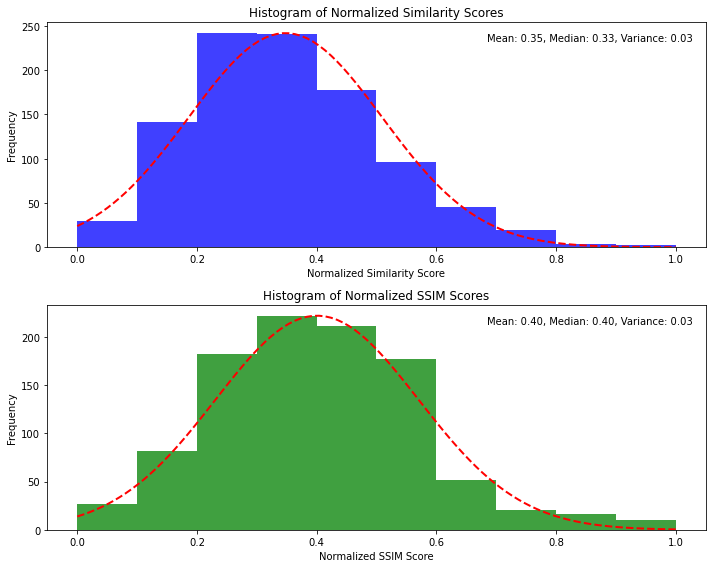

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


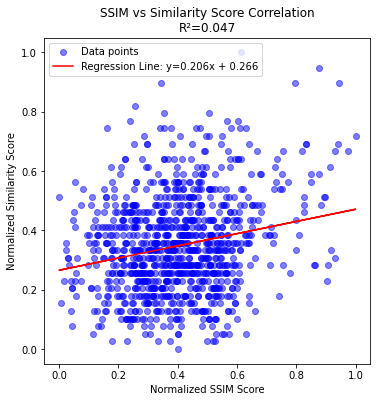

(array([0.07692308, 0.28205128, 0.41025641, 0.28205128, 0.17948718,
        0.17948718, 0.46153846, 0.41025641, 0.51282051, 0.28205128,
        0.43589744, 0.20512821, 0.38461538, 0.12820513, 0.74358974,
        0.1025641 , 0.48717949, 0.02564103, 0.35897436, 0.46153846,
        0.35897436, 0.23076923, 0.17948718, 0.20512821, 0.51282051,
        0.35897436, 0.05128205, 0.28205128, 0.15384615, 0.28205128,
        0.43589744, 0.51282051, 0.17948718, 0.51282051, 0.20512821,
        0.51282051, 0.28205128, 0.25641026, 0.38461538, 0.64102564,
        0.76923077, 0.38461538, 0.38461538, 0.25641026, 0.23076923,
        0.51282051, 0.35897436, 0.15384615, 0.30769231, 0.25641026,
        0.43589744, 0.56410256, 0.64102564, 0.20512821, 0.35897436,
        0.23076923, 0.41025641, 0.30769231, 0.48717949, 0.38461538,
        0.38461538, 0.30769231, 0.51282051, 0.46153846, 0.43589744,
        0.48717949, 0.74358974, 0.28205128, 0.1025641 , 0.33333333,
        0.82051282, 0.1025641 , 0.17948718, 0.61

In [57]:
folder_path = '/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/CONFIGS/SStest/Stims/Stimuli/RenderPics'
analyze_similarity_distributions(folder_path, n_pairs=1000, n_bins=10)

In [17]:

# Main function to randomly draw pairs of images from a folder and calculate EfficientNet-based similarity and SS scores
def EN_SS_random_draw_and_plot(folder_path, num_pairs=10):
    # Load all images and their filenames from the folder
    images, filenames = load_images_and_filenames(folder_path)
    
    if len(images) < 2:
        print("Not enough images in the folder.")
        return
    
    # Load pretrained EfficientNetB0 model without the top classification layer (for feature extraction)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    
    efficientnet_similarities = []
    ss_scores = []
    
    # Randomly select pairs of images and calculate both EfficientNet-based similarity and SS scores
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(images)), 2)  # Randomly select two different indices
        
        img1, img2 = images[idx1], images[idx2]
        fname1, fname2 = filenames[idx1], filenames[idx2]
        
        # Extract feature embeddings using EfficientNet for both images
        features_img1 = extract_features(img1, base_model)
        features_img2 = extract_features(img2, base_model)
        
        # Calculate cosine similarity between the two feature vectors (EfficientNet-based similarity)
        cosine_sim = cosine_similarity([features_img1], [features_img2])[0][0]
        efficientnet_similarities.append(cosine_sim)
        
        # Extract dimensions from filenames and calculate similarity score (SS)
        dim_values1 = extract_dimensions(fname1)
        dim_values2 = extract_dimensions(fname2)
        
        ss_score = calculate_similarity_score(dim_values1, dim_values2)
        ss_scores.append(ss_score)

    # Normalize both EfficientNet-based similarities and SS scores to [0, 1]
    efficientnet_sim_normalized = (np.array(efficientnet_similarities) - np.min(efficientnet_similarities)) / \
                                  (np.max(efficientnet_similarities) - np.min(efficientnet_similarities))
    
    ss_scores_normalized = (np.array(ss_scores) - np.min(ss_scores)) / \
                           (np.max(ss_scores) - np.min(ss_scores))
    
    # Perform linear regression on normalized scores using sklearn's LinearRegression model
    X = efficientnet_sim_normalized.reshape(-1, 1)  # Reshape for sklearn's LinearRegression input format (n_samples, n_features)
    y = ss_scores_normalized
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Get regression line values: y_predicted based on X values (EfficientNet-based similarities)
    y_predicted = model.predict(X)

    # Get slope (coefficient) and intercept of regression line
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate R-squared value for goodness-of-fit measure
    r_squared = model.score(X, y)

    # Plotting the scatter plot of normalized EfficientNet-based similarities vs SS scores with regression line
    plt.figure(figsize=(6, 6))  # Set figure size to be square
    
    plt.scatter(efficientnet_sim_normalized, ss_scores_normalized, color='blue', alpha=0.7, label='Data points')
    
    # Plot regression line on top of scatter plot
    plt.plot(efficientnet_sim_normalized, y_predicted, color='red', label=f'Regression Line: y={slope:.3f}x + {intercept:.3f}')
    
    # Add title and labels with R-squared value displayed on the plot
    plt.title(f'Scatter Plot of Normalized EfficientNet Similarity vs Similarity Score (SS)\nR²={r_squared:.3f}')
    
    plt.xlabel('Normalized EfficientNet Similarity')
    plt.ylabel('Normalized Similarity Score (SS)')
    
    # Make sure the figure is square-shaped by setting equal aspect ratio for x and y axes.
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend()
    plt.savefig('/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/EfficientNetWithSSIM.eps', format='eps')
    plt.show()


In [ ]:
folder_path = '/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/CONFIGS/SStest/Stims/Stimuli/RenderPics'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')  # Suppress Keras messages
EN_SS_random_draw_and_plot(folder_path, num_pairs=1000)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import random
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Main function to randomly draw pairs of images from a folder and calculate VGG-based similarity and SS scores
def VGG_SS_random_draw_and_plot(folder_path, num_pairs=10):
    # Load all images and their filenames from the folder
    images, filenames = load_images_and_filenames(folder_path)
    
    if len(images) < 2:
        print("Not enough images in the folder.")
        return
    
    # Load pretrained VGG16 model without the top classification layer (for feature extraction)
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    
    vgg_similarities = []
    ss_scores = []
    
    # Randomly select pairs of images and calculate both VGG-based similarity and SS scores
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(images)), 2)  # Randomly select two different indices
        
        img1, img2 = images[idx1], images[idx2]
        fname1, fname2 = filenames[idx1], filenames[idx2]
        
        # Extract feature embeddings using VGG16 for both images
        features_img1 = extract_features(img1, base_model)
        features_img2 = extract_features(img2, base_model)
        
        # Calculate cosine similarity between the two feature vectors (VGG-based similarity)
        cosine_sim = cosine_similarity([features_img1], [features_img2])[0][0]
        vgg_similarities.append(cosine_sim)
        
        # Extract dimensions from filenames and calculate similarity score (SS)
        dim_values1 = extract_dimensions(fname1)
        dim_values2 = extract_dimensions(fname2)
        
        ss_score = calculate_similarity_score(dim_values1, dim_values2)
        ss_scores.append(ss_score)

    # Normalize both VGG-based similarities and SS scores to [0, 1]
    vgg_sim_normalized = (np.array(vgg_similarities) - np.min(vgg_similarities)) / \
                         (np.max(vgg_similarities) - np.min(vgg_similarities))
    
    ss_scores_normalized = (np.array(ss_scores) - np.min(ss_scores)) / \
                           (np.max(ss_scores) - np.min(ss_scores))
    
    # Perform linear regression on normalized scores using sklearn's LinearRegression model
    X = vgg_sim_normalized.reshape(-1, 1)  # Reshape for sklearn's LinearRegression input format (n_samples, n_features)
    y = ss_scores_normalized
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Get regression line values: y_predicted based on X values (VGG-based similarities)
    y_predicted = model.predict(X)

    # Get slope (coefficient) and intercept of regression line
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate R-squared value for goodness-of-fit measure
    r_squared = model.score(X, y)

    # Plotting the scatter plot of normalized VGG-based similarities vs SS scores with regression line
    plt.figure(figsize=(6, 6))  # Set figure size to be square
    
    plt.scatter(vgg_sim_normalized, ss_scores_normalized, color='blue', alpha=0.7, label='Data points')
    
    # Plot regression line on top of scatter plot
    plt.plot(vgg_sim_normalized, y_predicted, color='red', label=f'Regression Line: y={slope:.3f}x + {intercept:.3f}')
    
    # Add title and labels with R-squared value displayed on the plot
    plt.title(f'Scatter Plot of Normalized VGG Similarity vs Similarity Score (SS)\nR²={r_squared:.3f}')
    
    plt.xlabel('Normalized VGG Similarity')
    plt.ylabel('Normalized Similarity Score (SS)')
    
    # Make sure the figure is square-shaped by setting equal aspect ratio for x and y axes.
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend()
    plt.savefig('/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/VGG2.eps', format='eps')
    plt.show()

VGG_SS_random_draw_and_plot(folder_path, num_pairs=1000)

In [71]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 20.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 14.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [72]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [76]:
def extract_dimensions_from_folder(folder_path):
    dimension_data = []
    filenames = []

    # Iterate through all images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            # Extract dimension values using the existing function
            dimension_values = extract_dimensions(filename)
            dimension_data.append(dimension_values)
            filenames.append(filename)

    # Convert list of dictionaries into a DataFrame
    dimension_df = pd.DataFrame(dimension_data)
    dimension_df['filename'] = filenames  # Add filenames to the DataFrame
    return dimension_df

In [78]:
def calculate_ssim_for_random_pairs(folder_path, num_pairs=10):
    # Extract all image filenames and their dimensions from the folder
    dimension_df = extract_dimensions_from_folder(folder_path)
    
    if len(dimension_df) < 2:
        print("Not enough images in the folder.")
        return
    
    ssim_scores_with_dimensions = []
    
    # Randomly select pairs of images and calculate SSIM scores along with their dimensions
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(dimension_df)), 2)  # Randomly pick two different indices
        
        fname1, fname2 = dimension_df['filename'][idx1], dimension_df['filename'][idx2]
        
        img1_path = os.path.join(folder_path, fname1)
        img2_path = os.path.join(folder_path, fname2)
        
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        
        if img1 is None or img2 is None:
            print(f"Error loading one of the images: {fname1}, {fname2}")
            continue
        
        # Calculate SSIM score for the pair of images
        ssim_score = calculate_ssim(img1, img2)
        
        # Extract dimensions for both images from the DataFrame
        dims_img1 = dimension_df.iloc[idx1].drop('filename').to_dict()
        dims_img2 = dimension_df.iloc[idx2].drop('filename').to_dict()
        
        # Append the result as a tuple (dimensions_img1, dimensions_img2, SSIM score)
        ssim_scores_with_dimensions.append((dims_img1, dims_img2, ssim_score))
    
    return pd.DataFrame(ssim_scores_with_dimensions, columns=['Dimensions_Image1', 'Dimensions_Image2', 'SSIM'])


In [83]:
# Example usage:
folder_path = '/Users/wenxuan/Documents/MATLAB/WWW_config_maker_new/CONFIGS/SStest/Stims/Stimuli/RenderPics' # Replace with your actual folder path

# Step 1: Calculate SSIM scores for random pairs of images in the folder along with their dimensions.
ssim_with_dims_df = calculate_ssim_for_random_pairs(folder_path, num_pairs=5000)
# print("\nSSIM Scores with Dimensions for Random Pairs:")
# print(ssim_with_dims_df.head())

In [79]:
# Step 1: Prepare the data by calculating differences between corresponding dimensions
def calculate_dimension_comparisons(ssim_with_dims_df):
    # Create a new DataFrame to store dimension comparisons
    comparison_data = []
    
    for index, row in ssim_with_dims_df.iterrows():
        dims_img1 = row['Dimensions_Image1']
        dims_img2 = row['Dimensions_Image2']
        
        # Calculate comparisons between corresponding dimensions (0 if same, 1 if different)
        comparison = {key: (1 if abs(dims_img1[key] - dims_img2[key]) > 0 else 0) for key in dims_img1.keys()}
        comparison['SSIM'] = row['SSIM']  # Add SSIM score for this pair
        
        comparison_data.append(comparison)
    
    # Convert list of dictionaries into a DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    return comparison_df

# Step 2: Fit a Generalized Linear Model (GLM) to predict SSIM based on dimension differences
def fit_glm(diff_df):
    # Set independent variables (dimension differences) and dependent variable (SSIM score)
    X = diff_df.drop(columns=['SSIM'])  # All dimension differences are independent variables
    X = sm.add_constant(X)  # Add intercept term
    Y = diff_df['SSIM']  # SSIM is the dependent variable
    
    # Fit GLM model using Gaussian family (since we're predicting continuous similarity scores)
    glm_model = sm.GLM(Y, X, family=sm.families.Gaussian())
    glm_results = glm_model.fit()
    
    return glm_results

# Step 3: Interpret the GLM results
def interpret_glm_results(glm_results):
    summary_table = glm_results.summary()
    
    print(summary_table)
    
    # Extract coefficients and p-values for interpretation
    coeffs = glm_results.params
    p_values = glm_results.pvalues
    
    interpretation = []
    
    for dim, p_value in p_values.items():
        if p_value < 0.05:
            interpretation.append(f'{dim} is statistically significant. A change in this dimension significantly affects the SSIM score.')
        else:
            interpretation.append(f'{dim} is not statistically significant. A change in this dimension does not significantly affect the SSIM score.')
    
    return interpretation



In [84]:
# Example usage:

# Step 1: Calculate dimension differences from ssim_with_dims_df
diff_df = calculate_dimension_comparisons(ssim_with_dims_df)

# Step 2: Fit GLM to predict SSIM based on dimension differences
glm_results = fit_glm(diff_df)

# Step 3: Interpret GLM results and output how much each dimension affects SSIM changes
interpretation = interpret_glm_results(glm_results)

print("\nInterpretation of GLM Results:")
for line in interpretation:
    print(line)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   SSIM   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4983
Model Family:                Gaussian   Df Model:                           16
Link Function:               Identity   Scale:                       0.0018767
Method:                          IRLS   Log-Likelihood:                 8609.4
Date:                Fri, 01 Nov 2024   Deviance:                       9.3515
Time:                        13:27:44   Pearson chi2:                     9.35
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2804
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8753      0.007    120.716      0.0